In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t import CorticalColumn, LayerConnection, ComplexStructure, AbstractRewardSystem, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection

In [2]:
seed = random.randint(0,9999999)
print(seed)

9364248


In [3]:
# seed = 1400
# random.seed(seed)
# np.random.seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.manual_seed(seed)

In [4]:
input_size = 100
each_session = 30
session_number = 1000
layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

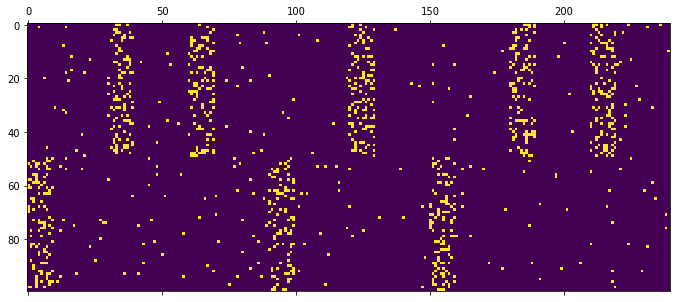

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args = { # Between Layer
    'wmin': 0.,
    'wmax': 2.7,
    'nu': 0.05, # [-, +]
    'probability': 0.3,
    'weight_decay': 0.00000,
    'update_rule': MSTDP_SEASONAL,
    
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
layer_args_l23 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -3.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 0,
    }
}
layer_args_l4 = {
    'exc_size': 50,
    'inh_con_args': { # Inside Layer
        'wmin': -0.6,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.50,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'rest':-57
    }
}
connection_type = RandomConnection

In [8]:
input_pop_c2 = Input(input_size, traces=True, tc_trace=10)
c2 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, connection_type, name="c2", monitor=LAYER_23|LAYER_4)
input_to_c2_connection = LayerConnection(("input_c2", input_pop_c2), c2, connection_type, {
    'wmin': 0.,
    'wmax': 2.0,
    'nu': 0.04,
#     'update_rule': MSTDPET_SEASONAL,
    'update_rule': PostPre,
    'probability': 0.50
})

In [9]:
c2_with_input = ComplexStructure()
c2_with_input.add_pop('input_c2', input_pop_c2)
c2_with_input.add_submodule(c2)
c2_with_input.add_submodule(input_to_c2_connection)
c2_with_input.add_outpops(c2.get_output_pops())

In [10]:
network = Network(dt=1.0)
c2_with_input.add_to_network(network)

bl_monitors = []
bl_monitors_name = []
for a, b, con in c2.l4_l23.connections + input_to_c2_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [11]:
# Disable layer 2,3
c2.l23.disable_learning()
c2.l4_l23.disable_learning()

In [12]:
for x in c2.l4_l23.connections:
    print(x[2].update_rule)

In [13]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c2' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

    if part == layer23_involve_from:
        c2.l4.disable_learning()
        input_to_c2_connection.disable_learning()
        
        c2.l23.enable_learning()
        c2.l4_l23.enable_learning()
        
        
    inp = {'input_c2': spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c2.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c2.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c2.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c2.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern and exc1_act > 20 and exc2_act < 5:
        reward = 1.0 + gap
    elif not pattern and exc2_act > 20 and exc1_act < 5:
        reward = 1.0 + gap
    elif exc1_wins != pattern:
        reward = -1 - gap
    else:
        reward = -0.1
        
    rewards.append(reward)
    
    for conn in c2.l4_l23.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.26parts/s]


In [14]:
c2.l23.disable_learning()
c2.l4_l23.disable_learning

<bound method AbstractConnectable.disable_learning of <libs.second_appr_simp_t.LayerConnection object at 0x0000022362203610>>

In [15]:
session_class[-300:]

tensor([False, False, False, False,  True, False, False, False,  True,  True,
         True, False, False,  True, False, False,  True, False,  True,  True,
         True, False,  True, False,  True,  True, False,  True, False, False,
        False,  True,  True, False, False,  True,  True, False,  True, False,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True, False, False, False, False, False, False,
         True, False, False, False,  True, False,  True, False,  True, False,
        False, False, False,  True,  True, False,  True, False,  True, False,
        False,  True, False, False, False,  True, False,  True, False,  True,
        False, False,  True, False, False,  True, False, False,  True, False,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True, False,  True,  True,  True, False,  True, False, False, False,
         True, False, False,  True, False,  True,  True, False, 

In [16]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('c2_l4__exc1', 'c2_l23__exc1')
('c2_l4__exc1', 'c2_l23__exc2')
('c2_l4__exc2', 'c2_l23__exc1')
('c2_l4__exc2', 'c2_l23__exc2')
('input_c2', 'c2_l4__exc1')
('input_c2', 'c2_l4__exc2')


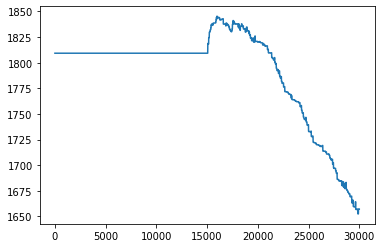

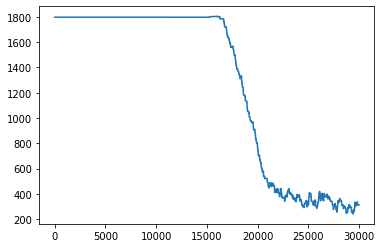

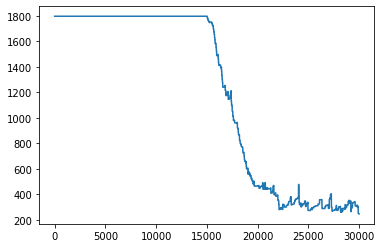

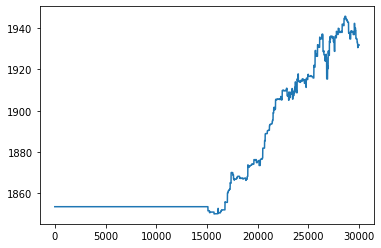

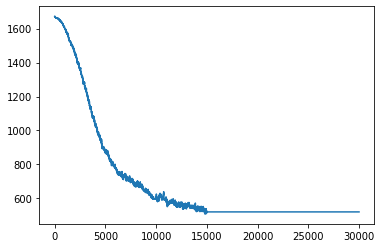

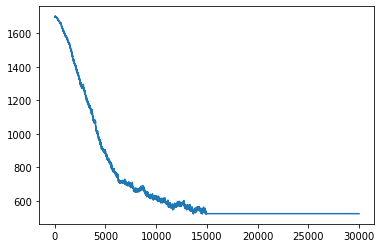

In [17]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [18]:
# plt.plot(inp_2_c1_monitor_1.get('converge'))
# plt.figure()
# plt.plot(inp_2_c1_monitor_2.get('converge'))

In [19]:
time_show = time

In [20]:
spikes = {
    "L4 | 1": c2.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c2.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c2.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -600:][:, timestep_class[-600:]].sum() / session_class[-20:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -600:][:, ~ timestep_class[-600:]].sum() / (~ session_class)[-20:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -600:][:, timestep_class[-600:]].sum() / session_class[-20:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -600:][:, ~ timestep_class[-600:]].sum() / (~ session_class)[-20:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.2222222238779068
L4 -- Excitatory 1 -- Pattern 2     :    45.6363639831543
L4 -- Excitatory 2 -- Pattern 1     :    46.66666793823242
L4 -- Excitatory 2 -- Pattern 2     :    0.3636363744735718


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.2800000011920929
L4 -- Excitatory 1 -- Pattern 2     :    43.52000045776367
L4 -- Excitatory 2 -- Pattern 1     :    46.52000045776367
L4 -- Excitatory 2 -- Pattern 2     :    0.4000000059604645


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.36000001430511475
L4 -- Excitatory 1 -- Pattern 2     :    44.599998474121094
L4 -- Excitatory 2 -- Pattern 1     :    45.91999816894531
L4 -- Excitatory 2 -- Pattern 2     :    0.2800000011920929


In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    13.36974811553955
L4 -- Excitatory 1 -- Pattern 2     :    46.19083786010742
L4 -- Excitatory 2 -- Pattern 1     :    45.766807556152344
L4 -- Excitatory 2 -- Pattern 2     :    12.406488418579102


### Layer 2,3

In [25]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    95.91999816894531
L4 -- Excitatory 1 -- Pattern 2     :    0.11999999731779099
L4 -- Excitatory 2 -- Pattern 1     :    10.479999542236328
L4 -- Excitatory 2 -- Pattern 2     :    124.87999725341797


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    84.91999816894531
L23 -- Excitatory 1 -- Pattern 2     :    0.05999999865889549
L23 -- Excitatory 2 -- Pattern 1     :    15.239999771118164
L23 -- Excitatory 2 -- Pattern 2     :    129.16000366210938


In [27]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    81.27941131591797
L23 -- Excitatory 1 -- Pattern 2     :    43.10305404663086
L23 -- Excitatory 2 -- Pattern 1     :    16.361345291137695
L23 -- Excitatory 2 -- Pattern 2     :    63.50954055786133


## Pattern Separation

In [28]:
for source, target, connection in input_to_c2_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c2 (0:99)    --->   c2_l4__exc1   :   393.682373046875
input_c2 (100:199) --->   c2_l4__exc1   :   0.0
input_c2 (0:99)    --->   c2_l4__exc2   :   390.9306945800781
input_c2 (100:199) --->   c2_l4__exc2   :   0.0


In [29]:

for source, target, connection in c2.l4_l23.connections:
    print(f"{source}   --->   {target}   :   {connection.w.sum()}")

c2_l4__exc1   --->   c2_l23__exc1   :   1284.357421875
c2_l4__exc1   --->   c2_l23__exc2   :   3722.32275390625
c2_l4__exc2   --->   c2_l23__exc1   :   4075.5927734375
c2_l4__exc2   --->   c2_l23__exc2   :   2062.027587890625


## Activities

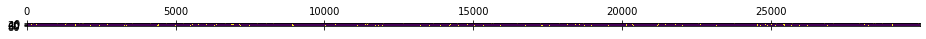

In [30]:
plt.matshow(spike_train.T[:, -time_show:])

In [31]:
c2.l4.monitors[0][1].get('s').shape

torch.Size([30000, 1, 50])

In [32]:
spikes["L4 | 1"].shape

torch.Size([50, 30000])

In [33]:
spikes["L4 | 1"].sum(0).shape[0]

30000

In [34]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [35]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(49)

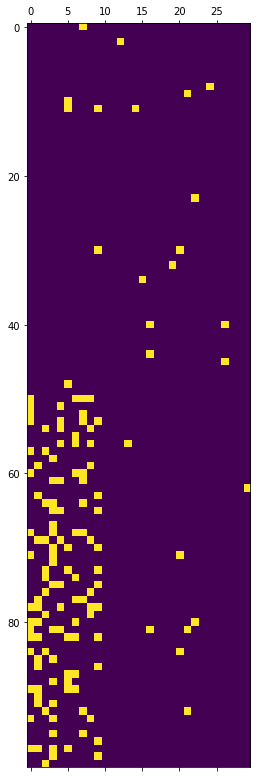

In [36]:
x = 396
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

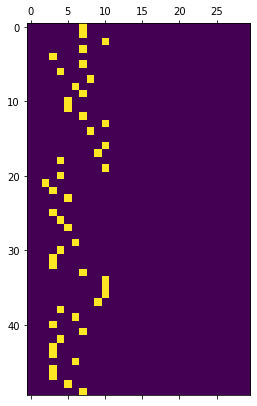

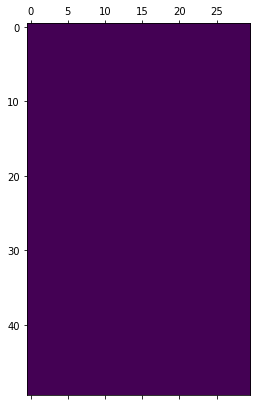

In [37]:
x = 398
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

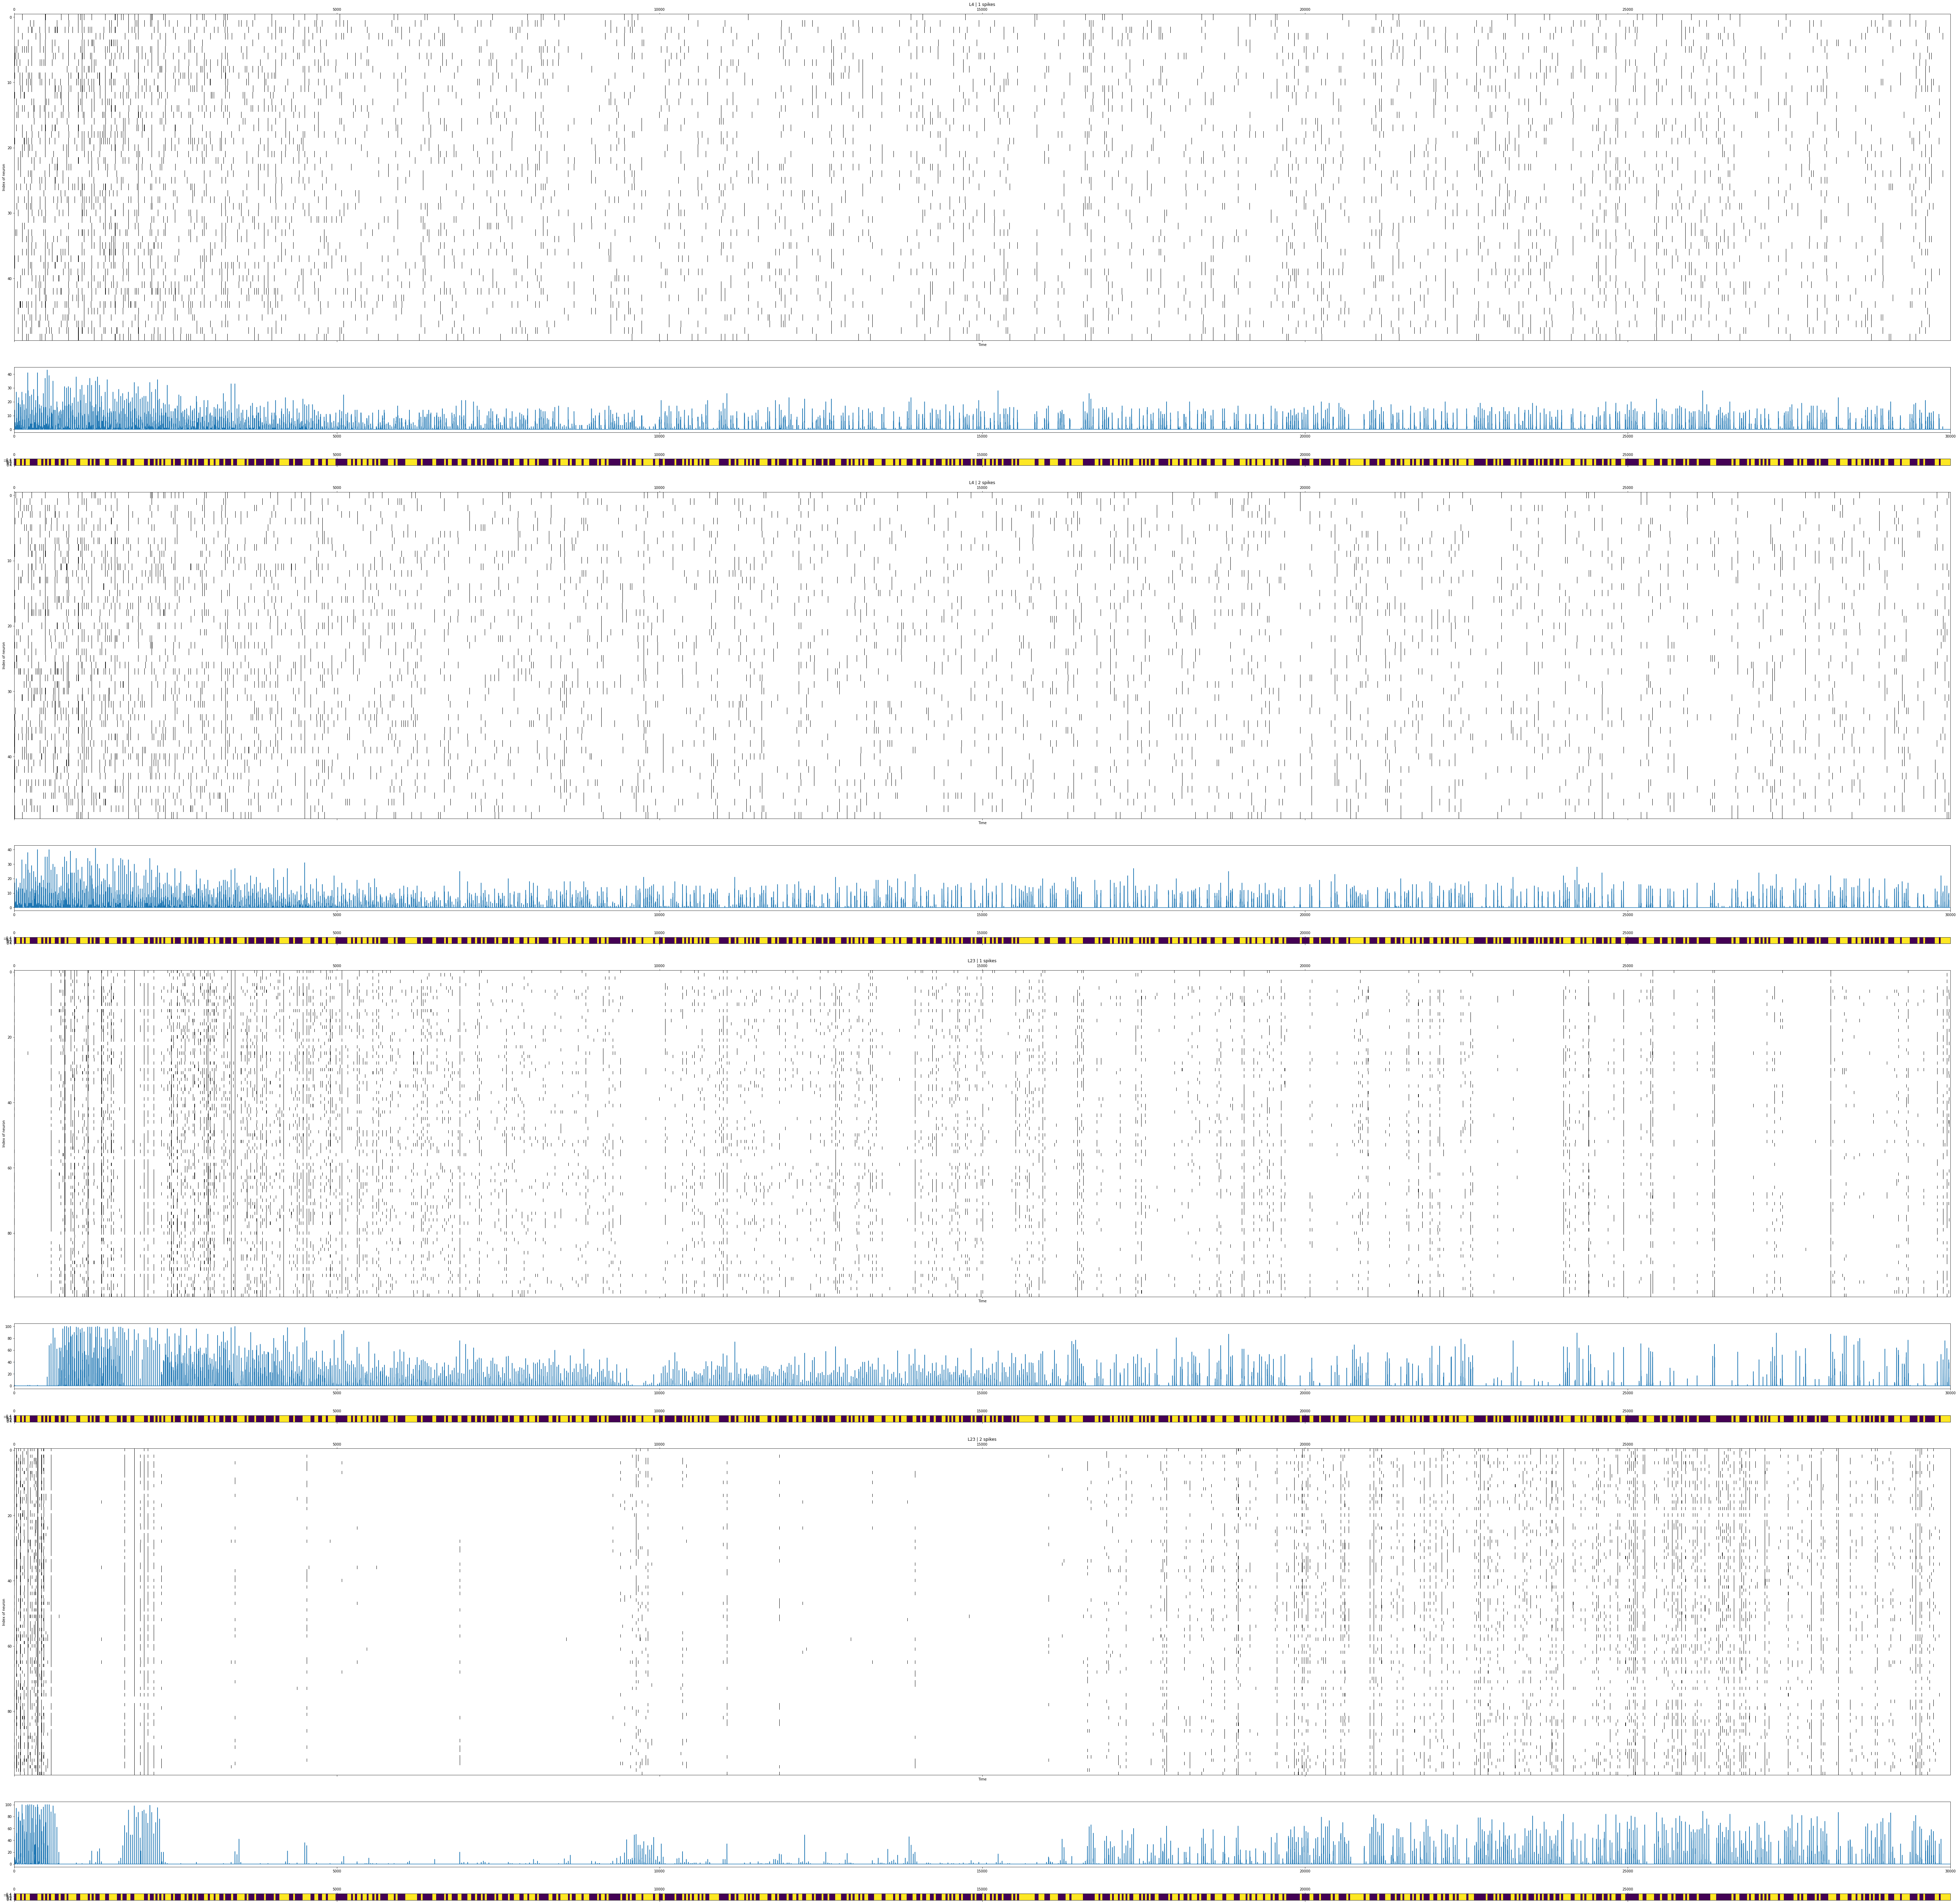

In [38]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

tensor(False)


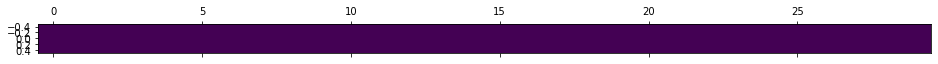

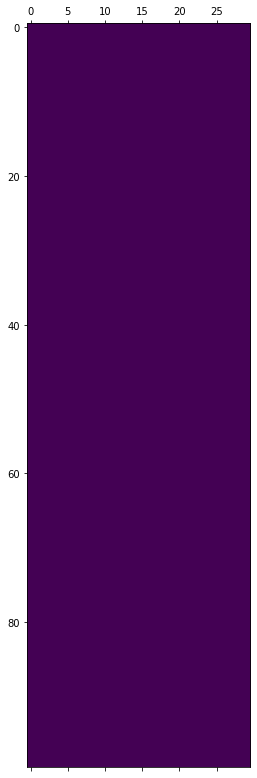

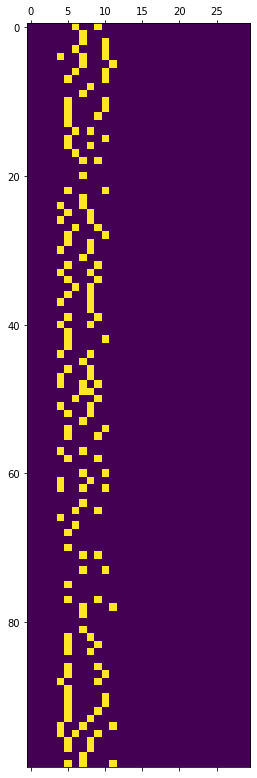

In [39]:
x = 794
print(session_class[x])
plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])

# Save Model And Notebook

In [40]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

<IPython.core.display.Javascript object>

In [41]:
model_name = 'c2'
c2_with_input.save(f'models/{model_name}.pt')
!! jupyter-nbconvert --to html .\c2-create.ipynb --stdout > models/{model_name}.html

['[NbConvertApp] Converting notebook .\\c2-create.ipynb to html']